# Three ways to do a two-way ANOVA with Python
From
https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/

(I cleaned up some of the text and some missing lines in the code) - Abe

In an earlier post I showed four different techniques that enables two-way analysis of variance (ANOVA) using Python. In this post we are going to learn how to do two-way ANOVA for independent measures using Python.

An important advantage of the two-way ANOVA is that it is more efficient compared to the one-way. There are two assignable sources of variation – supp and dose in our example – and this helps to reduce error variation thereby making this design more efficient. Two-way ANOVA (factorial) can be used to, for instance, compare the means of populations that are different in two ways. It can also be used to analyse the mean responses in an experiment with two factors. Unlike One-Way ANOVA, it enables us to test the effect of two factors at the same time. One can also test for independence of the factors provided there are more than one observation in each cell. The only restriction is that the number of observations in each cell has to be equal (there is no such restriction in case of one-way ANOVA).


We discussed linear models earlier – and ANOVA is indeed a kind of linear model – the difference being that ANOVA is where you have discrete factors whose effect on a continuous (variable) result you want to understand.



# Python 2-way ANOVA

In [4]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In the code above we import all the needed Python libraries and methods for doing two methods using Python (calculation with Python and using Statsmodels). As in the previous post on one-way ANOVA using Python we will use a set of data that is available in R but can be downloaded here: (Tooth Growth data) https://vincentarelbundock.github.io/Rdatasets/csv/datasets/ToothGrowth.csv

Pandas is used to create a dataframe that is easy to manipulate.

In [5]:
datafile="ToothGrowth.csv"
data = pd.read_csv(datafile)

It can be good to explore data before continuing with the inferential statistics. statsmodels has methods for visualising factorial data. We are going to use the method interaction_plot.

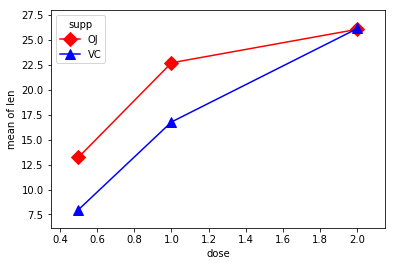

In [6]:
fig = interaction_plot(data.dose, data.supp, data.len,
             colors=['red','blue'], markers=['D','^'], ms=10)

## Calculation of sums of squares

The calculations of the sum of squares (the variance in the data) is quite simple using Python. First we start with getting the sample size (N) and the degree of freedoms needed. We will use them later to calculate the mean square. After we have the degree of freedom we continue with calculation of the sum of squares.

### Degrees of Freedom

In [7]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1
df_b = len(data.dose.unique()) - 1
df_axb = df_a*df_b 
df_w = N - (len(data.supp.unique())*len(data.dose.unique()))

### Sum of squares

For the calculation of the sum of squares A, B and Total we will need to have the grand mean. Using Pandas DataFrame method mean on the dependent variable only will give us the grand mean:

In [8]:
grand_mean = data['len'].mean()

The grand mean is simply the mean of all scores of len.

### Sum of Squares A – supp

We start with calculation of Sum of Squares for the factor A (supp).
Calculation of the second Sum of Square, B (dose), is pretty much the same but over the levels of that factor.
Sum of Squares Total is the sum over all

In [11]:
ssq_a = sum([(data[data.supp ==l].len.mean()-grand_mean)**2 for l in data.supp])
ssq_b = sum([(data[data.dose ==l].len.mean()-grand_mean)**2 for l in data.dose])
ssq_t = sum((data.len - grand_mean)**2)

### Sum of Squares Within (error/residual)
Finally, we need to calculate the Sum of Squares Within which is sometimes referred to as error or residual.

In [12]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]
ssq_w = sum((oj.len - oj_dose_means)**2) +sum((vc.len - vc_dose_means)**2)

### Sum of Squares interaction
Since we have a two-way design we need to calculate the Sum of Squares for the interaction of A and B.

In [13]:
ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w

### Mean Squares
We continue with the calculation of the mean square for each factor, the interaction of the factors, and within.

In [14]:
ms_a = ssq_a/df_a
ms_b = ssq_b/df_b
ms_axb = ssq_axb/df_axb
ms_w = ssq_w/df_w

### Mean Squares
We continue with the calculation of the mean square for each factor, the interaction of the factors, and within.

In [17]:
f_a = ms_a/ms_w
f_b = ms_b/ms_w
f_axb = ms_axb/ms_w

## Obtaining p-values
We can use the scipy.stats method f.sf to check if our obtained F-ratios is above the critical value. Doing that we need to use our F-value for each effect and interaction as well as the degrees of freedom for them, and the degree of freedom within.

In [18]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

The results are, right now, stored in a lot of variables. To obtain a  morereadable result we can create a DataFrame that will contain our ANOVA table.

In [19]:
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(>F)':[p_a, p_b, p_axb, 'NaN']}
columns=['sum_sq', 'df', 'F', 'PR(>F)']
 
aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['supp', 'dose', 
                          'supp:dose', 'Residual'])

Most psychology journals require to report effect sizes. Common software, such as, SPSS have eta squared as output. However, eta squared is an overestimation of the effect. To get a less biased effect size measure we can use omega squared. The following two functions adds eta squared and omega squared to the above DataFrame that contains the  ANOVA table.

In [20]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov
 
 
eta_squared(aov_table1)
omega_squared(aov_table1)
print(aov_table1)

                sum_sq  df        F       PR(>F)    eta_sq  omega_sq
supp        205.350000   1   15.572  0.000231183  0.059484  0.055452
dose       2426.434333   2       92  4.04629e-18  0.702864  0.692579
supp:dose   108.319000   2  4.10699    0.0218603  0.031377  0.023647
Residual    712.106000  54      NaN          NaN       NaN       NaN


# Two-way ANOVA using Statsmodels
There is, of course, a much easier way to do Two-way ANOVA with Python. We can use Statsmodels which have a similar model notation as many R-packages (e.g., lm). We start with formulation of the model:

formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

Statsmodels does not calculate effect sizes for us. My functions above can, again, be used and will add omega and eta squared effect sizes to the ANOVA table. Actually, I created these two functions to enable calculation of omega and eta squared effect sizes on the output of Statsmodels anova_lm method.

In [22]:
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

                      sum_sq    df          F        PR(>F)    eta_sq  \
C(supp)           205.350000   1.0  15.571979  2.311828e-04  0.059484   
C(dose)          2426.434333   2.0  91.999965  4.046291e-18  0.702864   
C(supp):C(dose)   108.319000   2.0   4.106991  2.186027e-02  0.031377   
Residual          712.106000  54.0        NaN           NaN       NaN   

                 omega_sq  
C(supp)          0.055452  
C(dose)          0.692579  
C(supp):C(dose)  0.023647  
Residual              NaN  


What is neat with using statsmodels is that we can also do some diagnostics. It is, for instance, very easy to take our model fit (the linear model fitted with the OLS method) and get a Quantile-Quantile (QQplot):

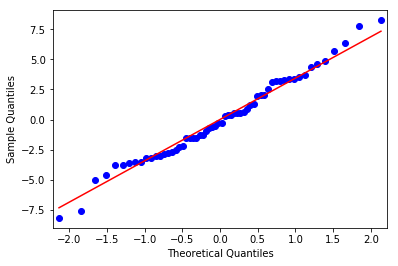

In [27]:
from statsmodels.graphics.gofplots import qqplot
res = model.resid 
fig = qqplot(res, line='s')
plt.show()